In [903]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from unidecode import unidecode
from rapidfuzz import process, fuzz
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

# Análisis de datos

In [905]:
df = pd.read_csv('Data/pf_suvs_i302_1s2025.csv')
df = df.drop(df.columns[0], axis=1)
mask = df['Moneda'] == '$'
df.loc[mask, 'Precio'] = df.loc[mask, 'Precio'] / 1185
df.drop(columns=['Moneda'], inplace=True)
df.drop(columns = ['Tipo de carrocería'],inplace=True)
df.dropna(subset=['Motor'], inplace=True)
idx = df[df['Año'] == 436694.0].index
df.drop(idx, inplace=True)

In [906]:
df.info()    
df.describe(include='all')  

<class 'pandas.core.frame.DataFrame'>
Index: 18215 entries, 0 to 18253
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Marca                    18215 non-null  object 
 1   Modelo                   18215 non-null  object 
 2   Año                      18215 non-null  float64
 3   Versión                  18215 non-null  object 
 4   Color                    17826 non-null  object 
 5   Tipo de combustible      18215 non-null  object 
 6   Puertas                  18215 non-null  float64
 7   Transmisión              18204 non-null  object 
 8   Motor                    18215 non-null  object 
 9   Con cámara de retroceso  4668 non-null   object 
 10  Kilómetros               18215 non-null  object 
 11  Título                   18215 non-null  object 
 12  Precio                   18215 non-null  float64
 13  Descripción              18215 non-null  object 
 14  Tipo de vendedor         18

,Marca,Modelo,Año,Versión,Color,Tipo de combustible,Puertas,Transmisión,Motor,Con cámara de retroceso,Kilómetros,Título,Precio,Descripción,Tipo de vendedor
count,18215,18215,18215.000000,18215,17826,18215,18215.000000,18204,18215,4668,18215,18215,18215.000000,18215,18215
unique,46,137,NaN,2054,69,8,NaN,4,271,2,2168,2197,NaN,12113,3
top,Ford,Ecosport,NaN,1.6 Exclusive Cvt,Gris,Nafta,NaN,Automática,1.6,Sí,0.0,Nissan Kicks 1.6 Exclusive Cvt,NaN,El vendedor no incluyó una descripción del pro...,concesionaria
freq,2154,1568,NaN,320,5457,16035,NaN,12255,4132,3724,4232,320,NaN,2254,8479
mean,NaN,NaN,2018.981279,NaN,NaN,NaN,18.195718,NaN,NaN,NaN,NaN,NaN,27560.119761,NaN,NaN
std,NaN,NaN,5.516133,NaN,NaN,NaN,892.720128,NaN,NaN,NaN,NaN,NaN,20220.151706,NaN,NaN
min,NaN,NaN,1981.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,100.421941,NaN,NaN
25%,NaN,NaN,2016.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,16033.755274,NaN,NaN
50%,NaN,NaN,2019.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,23465.822785,NaN,NaN
75%,NaN,NaN,2024.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,32376.640506,NaN,NaN


In [907]:
df.isnull().sum()     

Marca                          0
Modelo                         0
Año                            0
Versión                        0
Color                        389
Tipo de combustible            0
Puertas                        0
Transmisión                   11
Motor                          0
Con cámara de retroceso    13547
Kilómetros                     0
Título                         0
Precio                         0
Descripción                    0
Tipo de vendedor               0
dtype: int64

In [908]:
df['Puertas'] = df['Puertas'].replace(60252.0, np.nan)

# distribución de años

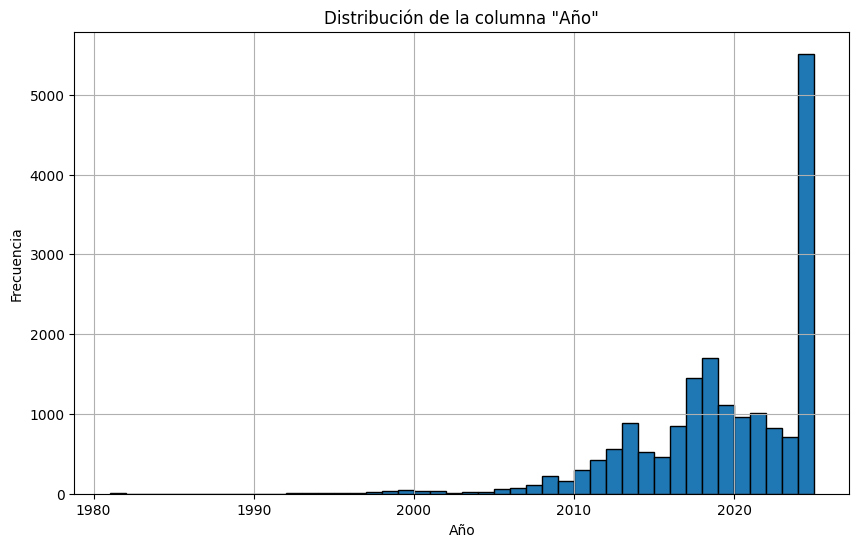

In [909]:
plt.figure(figsize=(10, 6))
plt.hist(df["Año"], bins=44, edgecolor='black')
plt.title(f'Distribución de la columna "{"Año"}"')
plt.xlabel("Año")
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Hay pocas muestras de autos viejos, capaz estaria bueno nivelarlas con alguno de los metodos que habiamos dado

# distribución puertas

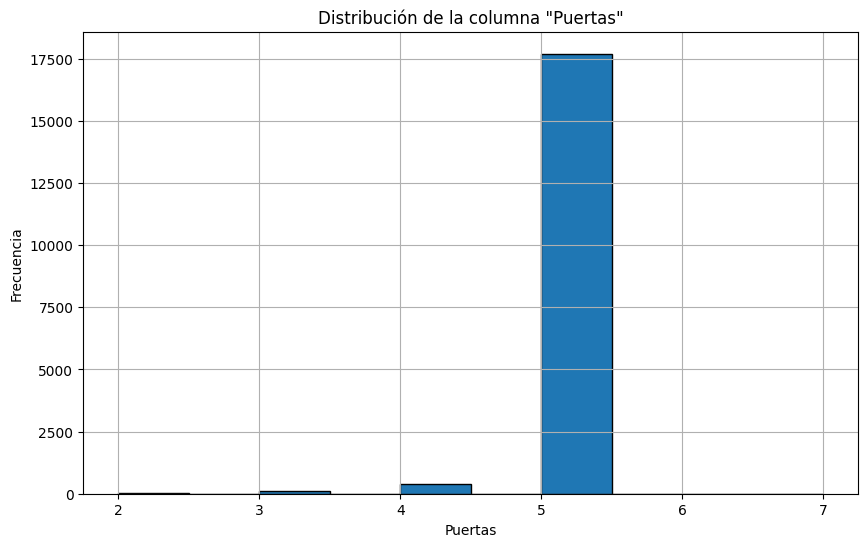

In [910]:
plt.figure(figsize=(10, 6))
plt.hist(df["Puertas"], bins=10, edgecolor='black')
plt.title(f'Distribución de la columna "{"Puertas"}"')
plt.xlabel("Puertas")
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Creo que no existen vehiculos de 2, 4, 6 o 7 puertas, habria que chequear eso. 

# distribucion precio

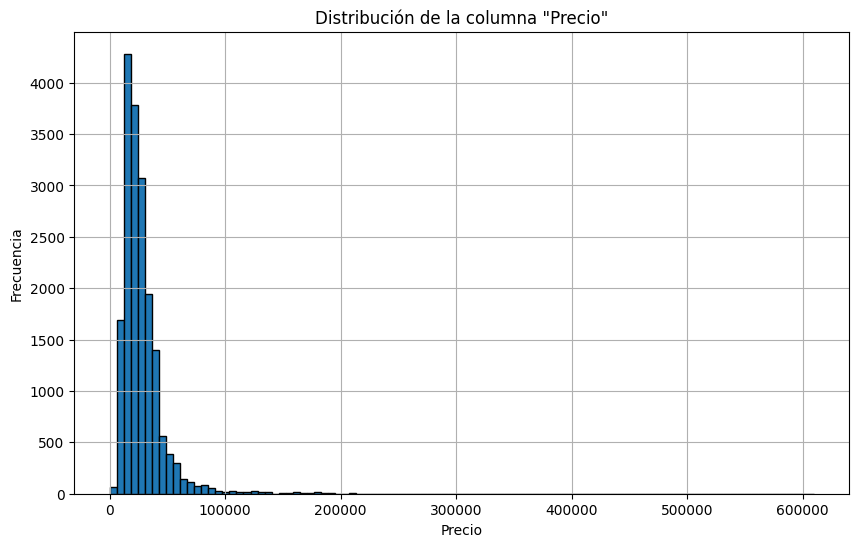

In [911]:
plt.figure(figsize=(10, 6))
plt.hist(df["Precio"], bins=100, edgecolor='black')
plt.title(f'Distribución de la columna "{"Precio"}"')
plt.xlabel("Precio")
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [912]:
df["Precio"].describe()  


count     18215.000000
mean      27560.119761
std       20220.151706
min         100.421941
25%       16033.755274
50%       23465.822785
75%       32376.640506
max      610000.000000
Name: Precio, dtype: float64

In [913]:
# df["log_Precio"] = np.log(df["Precio"])
# plt.figure(figsize=(10, 6))
# plt.hist(df["log_Precio"], bins=100, edgecolor='black')
# plt.title(f'Distribución de la columna "{"log_Precio"}"')
# plt.xlabel("log_Precio")
# plt.ylabel('Frecuencia')
# plt.grid(True)
# plt.show()

# mu = df["log_Precio"].mean()
# sigma = df["log_Precio"].std()

# outliers = df[np.abs(df["log_Precio"] - mu) > 3 * sigma]
# print(f"Número de outliers: {len(outliers)}")

In [914]:
# df= df[np.abs(df["log_Precio"] - mu) <= 3 * sigma].copy()
# df["Precio"] = np.exp(df["log_Precio"])


# codificacion

In [915]:
mappings = {
    'Con cámara de retroceso': {'No': 0, 'Sí': 1},
    'Transmisión': {
        'Automática': 0,
        'Manual': 1,
        'Automática secuencial': 2,
        'Semiautomática': 3
    }
}

for col, mapping in mappings.items():
    code_col = col.replace(' ', '_') + '_code'
    df[code_col] = df[col].map(mapping)

enc = OrdinalEncoder()
df[['Modelo_code', 'Version_code']] = enc.fit_transform(df[['Modelo', 'Versión']])

imputer = KNNImputer(n_neighbors=5, weights='uniform')
cols_to_impute = ['Modelo_code', 'Año', 'Version_code'] + [c.replace(' ', '_') + '_code' for c in mappings]
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

for col, mapping in mappings.items():
    code_col = col.replace(' ', '_') + '_code'
    df[code_col] = np.round(df[code_col]).astype(int)
    inv_map = {v: k for k, v in mapping.items()}
    df[col] = df[code_col].map(inv_map)

df['Puertas'] = df['Puertas'].replace(60252.0, np.nan)
imputer = KNNImputer(n_neighbors=5)
cols = ['Modelo_code', 'Año','Version_code','Puertas']
df[cols] = imputer.fit_transform(df[cols])
df['Puertas'] = np.round(df['Puertas']).astype(int)

aux_cols = ['Modelo_code', 'Version_code'] + [c.replace(' ', '_') + '_code' for c in mappings]
df.drop(aux_cols, axis=1, inplace=True)

print(df['Puertas'].value_counts(dropna=False))
print(df['Con cámara de retroceso'].value_counts(dropna=False))
print(df['Transmisión'].value_counts(dropna=False))

df['Kilómetros'] = (
    df['Kilómetros']
      .str.replace(r'\s*km$', '', regex=True)  
      .str.replace(r'\.', '', regex=True)      
      .astype(float)
)
print( df['Kilómetros'].value_counts(dropna=False))

Puertas
5    17700
4      395
3      105
2       10
6        3
7        2
Name: count, dtype: int64
Con cámara de retroceso
Sí    13768
No     4447
Name: count, dtype: int64
Transmisión
Automática               12263
Manual                    5831
Automática secuencial      120
Semiautomática               1
Name: count, dtype: int64
Kilómetros
0.0          4556
10000.0       219
900000.0      194
1200000.0     193
1000000.0     176
             ... 
1286830.0       1
962020.0        1
808000.0        1
1173760.0       1
1231290.0       1
Name: count, Length: 2140, dtype: int64


In [916]:
def normalize(text):
    return unidecode(text).lower().strip()

df['color_norm'] = df['Color'].astype(str).apply(normalize)

canonical = [
    'Blanco','Negro','Gris','Azul','Rojo','Verde','Amarillo',
    'Naranja','Celeste','Bordo','Marrón','Violeta','Rosa',
    'Plateado','Dorado','otro','cafe'
]
canonical_lower = [c.lower() for c in canonical]

overrides = {
    'cafe':                         'cafe',
    'blanco nacre tricapa':         'Blanco',
    'steel_blue':                   'Azul',
    'gris selenium':                'Gris',
    'summit white':                 'Blanco',
    'mineralweiss metallic':        'Gris',
    'skyscraper grau metallic':     'Gris',
    'granite crysta bc':            'Gris',
    'prata bari+tet vulc':          'Plateado',
    'champaing':                    'Dorado',
    'noir perla nera':              'Negro',
    'black meet kettle':            'Negro',
    'granite crystal bc':           'Gris',
    'blue':                         'Azul',
    'beige techo negro':            'Marrón',
    'rojo sunset metalizado':       'Rojo',
    'gris artense':                 'Gris',
    'moundaz':                      'otro',
    'blanco banchisa bicolor negro':'Blanco'
}

def map_color(name):
    if name in overrides:
        return overrides[name]
    match, score, _ = process.extractOne(name, canonical_lower, scorer=fuzz.token_sort_ratio)
    if score >= 40:
        return canonical[canonical_lower.index(match)]
    return None

df['color_estandar'] = df['color_norm'].apply(map_color)
print( df['color_estandar'].value_counts(dropna=False))
df['Color']=df['color_estandar']
df.drop(columns=['color_estandar','color_norm'], inplace=True)

color_estandar
Gris        5519
Blanco      4814
Negro       2958
Plateado    1437
Azul        1121
Rojo        1116
Naranja      462
Marrón       258
Dorado       193
Verde        137
Celeste       94
Violeta       33
Bordo         29
Amarillo      25
otro           8
Rosa           8
cafe           3
Name: count, dtype: int64


In [917]:
canonical_brands = [
    'Ford','Volkswagen','Jeep','Chevrolet','Renault','Toyota','Peugeot','Nissan',
    'Citroën','BMW','Honda','Hyundai','Audi','Fiat','Chery','Kia',
    'Mercedes-Benz','Dodge','BAIC','Suzuki','Land Rover','Porsche',
    'Mitsubishi','Volvo','SsangYong','D.S.','Alfa Romeo','JAC','Jetour',
    'Haval','GWM','Lifan','Lexus','Isuzu','Subaru','Daihatsu','Mini','otro'
]
canonical_lower = [c.lower() for c in canonical_brands]

overrides = {
    'rrenault':               'Renault',
    'hiunday':                'Hyundai',
    'vol':                    'Volvo',
    'range rover':            'Land Rover',
    'ds automobiles':         'D.S.',
    'd.s':                    'D.S.',
    'd·s':                    'D.S.',
}
def map_brand(name):
    if name in overrides:
        return overrides[name]
    match, score, _ = process.extractOne(name, canonical_lower, scorer=fuzz.token_sort_ratio)
    if score >= 80:
        return canonical_brands[canonical_lower.index(match)]
    return 'otro'

df['brand_norm'] = df['Marca'].apply(normalize)
df['Marca_limpia'] = df['brand_norm'].apply(map_brand)

df['Marca'] = df['Marca_limpia']

df.drop(columns=['brand_norm','Marca_limpia'], inplace=True)

print(df['Marca'].value_counts(dropna=False))


Marca
Ford             2154
Jeep             2048
Volkswagen       2036
Chevrolet        1747
Renault          1490
Toyota           1256
Peugeot          1247
Nissan           1059
Citroën           716
BMW               667
Honda             596
Hyundai           571
Audi              529
Fiat              366
Chery             344
Kia               290
Mercedes-Benz     282
Dodge             185
BAIC              164
Suzuki             76
Porsche            67
Land Rover         63
Mitsubishi         47
Volvo              38
SsangYong          30
D.S.               28
Alfa Romeo         25
JAC                19
Jetour             15
Haval               9
GWM                 9
otro                8
Isuzu               8
Lifan               7
Lexus               7
Subaru              5
Daihatsu            4
Mini                3
Name: count, dtype: int64


In [918]:

df['modelo_norm'] = df['Modelo'].apply(normalize)

overrides_model = {
    'sw4':        'hilux sw4',
    'hilux sw4': 'hilux sw4',
    'x55':       'x5',
    'q5 sportback': 'q5 sportback',
    'q3 sportback': 'q3 sportback',
    'grand santa fe': 'santa fe'
}

df['modelo_final'] = df['modelo_norm'].map(lambda x: overrides_model.get(x, x))
df['Modelo'] = df['modelo_final']
df.drop(columns=['modelo_final','modelo_norm'], inplace=True)
print(df['Modelo'].value_counts())


Modelo
ecosport    1568
tracker     1508
2008        1143
duster      1047
compass      916
            ... 
samurai        2
sandero        2
208            2
defender       2
f-pace         2
Name: count, Length: 134, dtype: int64


Freq Encoder

In [ ]:
class IncrementalFreqEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, alpha=1.0, bucket_other=True):
        self.cols         = cols
        self.alpha        = alpha
        self.bucket_other = bucket_other

    def fit(self, X, y=None):
        self.N_      = len(X)
        self.counts_ = {col: X[col].value_counts().to_dict()
                        for col in self.cols}
        self.K_ = {col: len(self.counts_[col]) for col in self.cols}
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.cols:
            cnts = self.counts_[col]
            N    = self.N_
            K    = self.K_[col]
            α    = self.alpha

            freq_map = {cat: (cnt + α) / (N + α * K)
                        for cat, cnt in cnts.items()}
            default = α / (N + α * K)

            if self.bucket_other:
                known = set(cnts.keys())
                X[col] = X[col].where(X[col].isin(known), 'Other')
                freq_map['Other'] = default

            X[col + '_freq'] = X[col].map(freq_map).fillna(default)

        return X

    def partial_fit(self, X, y=None):
        """
        (Opcional) incorporar X a tu histórico:
        suma conteos y actualiza N_, K_, counts_
        """
        for col in self.cols:
            new_counts = X[col].value_counts().to_dict()
            for cat, cnt in new_counts.items():
                self.counts_[col][cat] = self.counts_[col].get(cat, 0) + cnt
            self.K_[col] = len(self.counts_[col])
        self.N_ += len(X)
        return self


FEATURE ENGENEERING

In [ ]:
df['Edad']= 2026 - df['Año']
df['log_km'] = np.log1p(df['Kilómetros'])
df['km_per_year'] = df['Kilómetros'] / (df['Edad'])

Categorías nuevas en test: {'Marca': 0, 'Modelo': 2, 'Versión': 222, 'Color': 0, 'Tipo de combustible': 0, 'Transmisión': 0, 'Motor': 34, 'Con cámara de retroceso': 0, 'Título': 249, 'Descripción': 2205, 'Tipo de vendedor': 0, 'Edad': 0, 'km_per_year': 471}


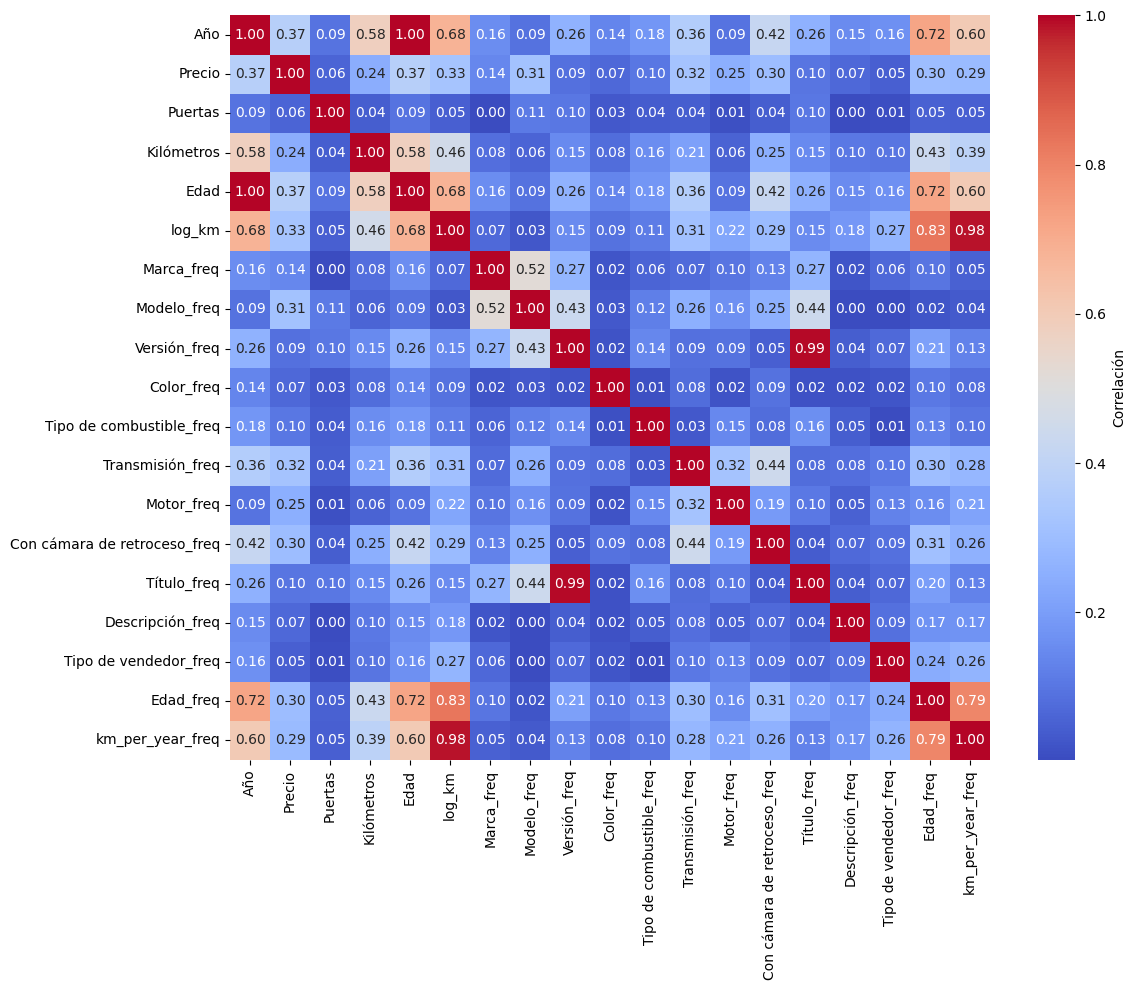

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

exclude      = ['Año', 'Precio', 'Puertas', 'Kilómetros', 'log_km']
categoricals = [c for c in df.columns if c not in exclude]

enc = IncrementalFreqEncoder(
    cols=categoricals,
    alpha=5.0,
    bucket_other=True
)
enc.fit(train_df)   

unknown_counts = {}
for col in categoricals:
    known = set(enc.counts_[col].keys())
    mask = ~test_df[col].isin(known)
    unknown_counts[col] = mask.sum()

print("Categorías nuevas en test:", unknown_counts)


train_enc = enc.transform(train_df)
test_enc  = enc.transform(test_df)

freq_feats = [col + '_freq' for col in categoricals]

numeric_cols = ['Año', 'Precio', 'Puertas', 'Kilómetros','Edad', 'log_km']
df_corr      = train_enc[numeric_cols + freq_feats]

corr_matrix = df_corr.corr(method='pearson').abs()

plt.figure(figsize=(12,10))
sns.heatmap(
    corr_matrix,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label':'Correlación'}
)
plt.tight_layout()
plt.show()


Preparacion para el entrenamiento

In [922]:
freq_feats.remove('Título_freq')
freq_feats.remove('Descripción_freq')


train_enc.drop(columns=['Título_freq', 'Descripción_freq'], inplace=True)
test_enc.drop(columns=['Título_freq', 'Descripción_freq'], inplace=True)

df.to_csv('Data/pf_suvs_i302_1s2025_processed.csv', index=False,sep=',')  

numerical = ['Año', 'Puertas', 'Kilómetros','Edad', 'log_km']
features  = numerical + freq_feats

X_train = train_enc[features]
X_test  = test_enc [features]
y_train = np.log(train_enc['Precio'])
y_test  = np.log(test_enc ['Precio'])


Entrenamiento con una Regresion Lineal con Ridge

In [923]:
alphas = np.logspace(-3, 1, 13)
ridge_pipeline = make_pipeline(
    StandardScaler(),
    RidgeCV(
        alphas=alphas,
        scoring='neg_root_mean_squared_error',
        cv=5
    )
)

ridge_pipeline.fit(X_train, y_train)

best_alpha = ridge_pipeline.named_steps['ridgecv'].alpha_
print("Mejor α (λ) según CV:", best_alpha)

y_pred_log = ridge_pipeline.predict(X_test)

y_test_orig = np.exp(y_test)
y_pred_orig = np.exp(y_pred_log)

rmse_test = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2_test   = r2_score(y_test_orig, y_pred_orig)
print(f"Test RMSE (USD): {rmse_test:,.0f}")
print(f"Test R² :   {r2_test:.3f}")


Mejor α (λ) según CV: 0.001
Test RMSE (USD): 15,612
Test R² :   0.342


Entrenamiento con Gradient Boosting

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros GBR: {'subsample': 1.0, 'n_estimators': 500, 'min_samples_leaf': 20, 'max_depth': 5, 'learning_rate': 0.1}
GBR Test RMSE (USD): 5,093
GBR Test R²      :   0.930


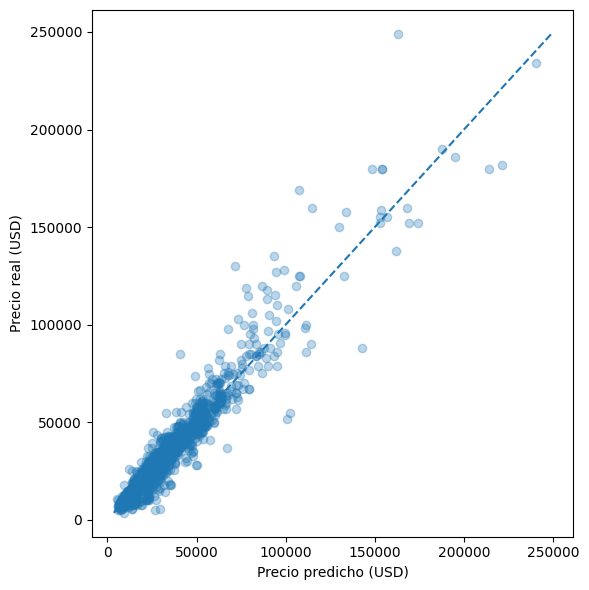

In [924]:
gbr = GradientBoostingRegressor(random_state=0)
param_dist = {
    'n_estimators':    [100, 300, 500],
    'learning_rate':   [0.01, 0.05, 0.1],
    'max_depth':       [3, 5, 7],
    'min_samples_leaf':[20, 50, 100],
    'subsample':       [0.8, 1.0]
}
search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    random_state=0,
    verbose=1
)
search.fit(X_train, y_train)

best_gbr   = search.best_estimator_
y_pred_log = best_gbr.predict(X_test)

y_test_orig = np.exp(y_test)
y_pred_orig = np.exp(y_pred_log)

rmse_test = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2_test   = r2_score(y_test_orig, y_pred_orig)
print("Mejores parámetros GBR:", search.best_params_)
print(f"GBR Test RMSE (USD): {rmse_test:,.0f}")
print(f"GBR Test R²      :   {r2_test:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_pred_orig, y_test_orig, alpha=0.3)
mn, mx = y_test_orig.min(), y_test_orig.max()
plt.plot([mn, mx], [mn, mx], ls='--')
plt.xlabel("Precio predicho (USD)")
plt.ylabel("Precio real (USD)")
plt.tight_layout()
plt.show()


In [925]:
pipe_cb = Pipeline([
    ('scaler', StandardScaler()),
    ('cb', CatBoostRegressor(
        random_seed=0,
        verbose=0,
        early_stopping_rounds=50,
        eval_metric='RMSE',
        allow_writing_files=False
    ))
])

search_spaces = {
    'cb__iterations':       (500, 2000),
    'cb__learning_rate':    (1e-3, 0.3, 'log-uniform'),
    'cb__depth':            (4, 12),
    'cb__l2_leaf_reg':      (1, 20),
    'cb__bagging_temperature': (0.0, 1.0),
    'cb__border_count':     (32, 255),
    'cb__subsample':        (0.6, 1.0)
}

opt = BayesSearchCV(
    estimator=pipe_cb,
    search_spaces=search_spaces,
    n_iter=10,                                
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train, y_train)

print("Mejores parámetros CatBoost (BayesSearch):")
print(opt.best_params_)

y_pred_log_cb = opt.predict(X_test)
y_true = np.exp(y_test)
y_pred = np.exp(y_pred_log_cb)

rmse_cb = np.sqrt(mean_squared_error(y_true, y_pred))
r2_cb   = r2_score(y_true, y_pred)

print(f"CatBoost Test RMSE (USD): {rmse_cb:,.0f}")
print(f"CatBoost Test R²:   {r2_cb:.3f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores parámetros CatBoost (BayesSearch):
OrderedDict([('cb__bagging_temperature', 0.7995534416071731), ('cb__border_count', 130), ('cb__depth', 8), ('cb__iterations', 1574), ('cb__l2_leaf_reg', 18), ('cb__learning_rate', 0.05972733054818639), ('cb__subsample', 0.7696712289842729)])
CatBoost Test RMSE (USD): 4,771
CatBoost Test R²:   0.939
